## Table of Contents
Classification 
1. Building Random Forest
2. Classification metric
3. Handling Imbalance in data<br>

Regression
1. Building Linear Regression
2. Loss function




In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *
from imblearn import under_sampling, over_sampling
from sklearn.ensemble import RandomForestClassifier
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score,precision_recall_curve
from sklearn.metrics import confusion_matrix,auc,roc_auc_score,roc_curve
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Classification 

Predict booking cancellation using Hotel booking data from kaggle

In [ ]:
file_path = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-11/hotels.csv'
data = pd.read_csv(file_path)

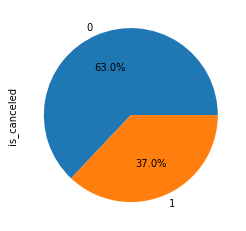

In [ ]:
data['is_canceled'].value_counts().plot(kind='pie',autopct='%1.1f%%')

#### Create higher class imbalance

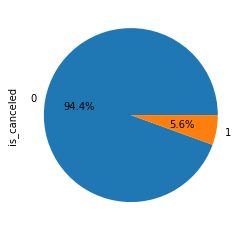

In [ ]:
df_1 = data[data['is_canceled']==1].sample(frac=0.1,random_state=42)
df_0=data[data['is_canceled']==0]
df = df_0.append(df_1,ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df['is_canceled'].value_counts().plot(kind='pie',autopct='%1.1f%%')

In [ ]:
backup_df = df.copy()

<b> Feature Engineering </b>

In [ ]:
# Fill null values with 0
df = df.drop('company',axis=1)
df=df.fillna(0)

In [ ]:
# Drop features that have less significance 
df = df.drop('reservation_status_date',axis=1)
df = df.drop('agent',axis=1)
df = df.drop('country',axis=1)
df = df.drop('previous_bookings_not_canceled',axis=1)
df = df.drop('previous_cancellations',axis=1)
df = df.drop(["reservation_status"],axis=1)

In [ ]:
# Generate new features
df['total_days'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
df = df.drop('stays_in_week_nights',axis=1).drop('stays_in_weekend_nights',axis=1)

df['total_customers'] = df['adults'] + df['children']+df['babies']
df = df.drop('adults',axis=1).drop('children',axis=1).drop('babies',axis=1)

In [ ]:
df.shape

(79588, 22)

### Building Random Forest
### Model 1

In [ ]:
# Split data into train and test set using stratified sampling
train, test = train_test_split(df, test_size=0.3, stratify=df["is_canceled"], random_state = 42)
y_train = train["is_canceled"]
X_train = train.drop(["is_canceled"], axis=1)
y_test = test["is_canceled"]
X_test = test.drop(["is_canceled"], axis=1)

In [ ]:
print(train[train['is_canceled']==1].shape[0])
print(test[test['is_canceled']==1].shape[0])

3095
1327


In [ ]:
cat_cols=['hotel','arrival_date_month','arrival_date_year','meal','market_segment','distribution_channel','reserved_room_type', 'assigned_room_type',\
        'deposit_type','customer_type']
X_train_enc = pd.get_dummies(data=X_train,columns=cat_cols,drop_first=True)
X_test_enc = pd.get_dummies(data=X_test,columns=cat_cols,drop_first=True)
X_train_enc,X_test_enc =X_train_enc.align(X_test_enc, join='left', axis=1)
X_test_enc=X_test_enc.fillna(0)

In [ ]:
rf=RandomForestClassifier(max_depth=10,n_estimators=20,random_state=24)
rf.fit(X_train_enc,y_train)
y_pred_rf=rf.predict(X_test_enc)
y_pred_rf_train=rf.predict(X_train_enc)

### Evaluation Metric

In [ ]:
# Using F1 score on train and test data prdiction we confirm the model is not overfit on training data
print("Train data f1 score: ", f1_score(y_train,y_pred_rf_train))
print("Test data f1 score: ", f1_score(y_test,y_pred_rf))

Train data f1 score:  0.5080742347553627
Test data f1 score:  0.5005649717514125


<b>Accuracy

In [ ]:
print("accuracy score: ", accuracy_score(y_test,y_pred_rf))

accuracy score:  0.962976923399087


<b>Precision Recall


<img src="https://github.com/TejalPatted/Introduction_to_ML_worskshop/blob/master/img/PR%20diagram1.PNG?raw=1" width="200p"/>

<img src="https://github.com/TejalPatted/Introduction_to_ML_worskshop/blob/master/img/PR%20diagram%202.PNG?raw=1" width="400"/>

In [ ]:
# Recall = TP / (TP + FN)
# Precision = TP / (TP + FP)
print("recall score: ", recall_score(y_test,y_pred_rf))
print("precision score: ", precision_score(y_test,y_pred_rf))

recall score:  0.333835719668425
precision score:  1.0


<b>Confusion Matrix

In [ ]:
# Predicted Label vs Actual label
#   N    P 
# N [TN  FP]
# P [FN  TP]
print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred_rf)) 

test-set confusion matrix:
 [[22550     0]
 [  884   443]]


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_rf).ravel()
(tn, fp, fn, tp)

(22550, 0, 884, 443)

<b>ROC curve

<img src="https://github.com/TejalPatted/Introduction_to_ML_worskshop/blob/master/img/ROC_curve.png?raw=1" width="400"/>

Text(0.5, 0, 'False Positive Rate')

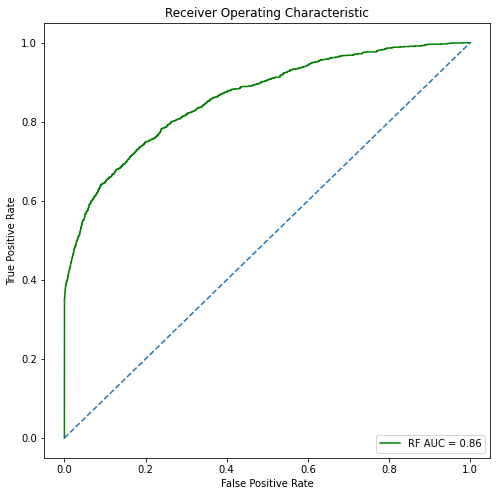

In [ ]:
# TPR = Recall = TP / (TP + FN)
# FPR = FP / (FP + TN)
y_prob_rf = rf.predict_proba(X_test_enc)
false_positive_rateRF, true_positive_rateRF, thresholdRF = roc_curve(y_test, y_prob_rf[:,1])
roc_aucRF = auc(false_positive_rateRF, true_positive_rateRF)
plt.figure(figsize = (8,8))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rateRF, true_positive_rateRF, color = 'green', label = 'RF AUC = %0.2f' % roc_aucRF)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

<b>Precision Recall Curve

<img src="https://github.com/TejalPatted/Introduction_to_ML_worskshop/blob/master/img/PR_curve.png?raw=1" width="400"/>

Best Threshold=0.143994, F-Score=0.535




Text(0.5, 0, 'Recall')

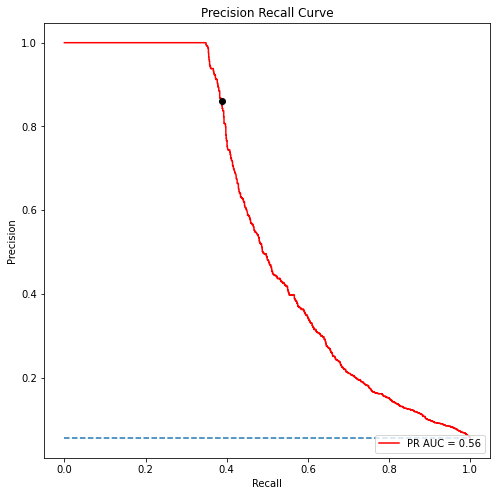

In [ ]:
y_prob_rf = rf.predict_proba(X_test_enc)
precision_rf, recall_rf, thresholds = precision_recall_curve(y_test, y_prob_rf[:,1])
pr_aucRF = auc(recall_rf, precision_rf)
plt.figure(figsize = (8,8))
plt.title('Precision Recall Curve')
plt.plot(recall_rf, precision_rf, color = 'red', label = 'PR AUC = %0.2f' % pr_aucRF)
plt.legend(loc = 'lower right')

# no_skill = Count of P / Total count
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1],  [no_skill, no_skill], linestyle = '--')

# Get best threshold
# convert to f score
fscore = (2 * precision_rf * recall_rf) / (precision_rf + recall_rf)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('\n')
plt.plot(recall_rf[ix], precision_rf[ix], marker='o', color='black', label='Best')

plt.axis('tight')
plt.ylabel('Precision')
plt.xlabel('Recall')

<b> Evaluation using K fold cross validation

In [ ]:
y = df["is_canceled"]
X = df.drop(["is_canceled"], axis=1)

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for train_ix, test_ix in kfold.split(X):
	# select rows
	train_X, test_X = X.iloc[train_ix], X.iloc[test_ix]
	train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
	# summarize train and test composition
	train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
	test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
	print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=60137, 1=3533, Test: 0=15029, 1=889
>Train: 0=60144, 1=3526, Test: 0=15022, 1=896
>Train: 0=60115, 1=3555, Test: 0=15051, 1=867
>Train: 0=60154, 1=3517, Test: 0=15012, 1=905
>Train: 0=60114, 1=3557, Test: 0=15052, 1=865


In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for train_ix, test_ix in kfold.split(X,y):
	# select rows
	train_X, test_X = X.iloc[train_ix], X.iloc[test_ix]
	train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
	# summarize train and test composition
	train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
	test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
	print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=60132, 1=3538, Test: 0=15034, 1=884
>Train: 0=60133, 1=3537, Test: 0=15033, 1=885
>Train: 0=60133, 1=3537, Test: 0=15033, 1=885
>Train: 0=60133, 1=3538, Test: 0=15033, 1=884
>Train: 0=60133, 1=3538, Test: 0=15033, 1=884


In [ ]:
cat_cols=['hotel','arrival_date_month','arrival_date_year','meal','market_segment','distribution_channel','reserved_room_type', 'assigned_room_type',\
        'deposit_type','customer_type']
X_enc = pd.get_dummies(data=X,columns=cat_cols,drop_first=True)

In [ ]:
scores = cross_val_score(rf, X_enc, y, cv = 5, scoring='f1')
print(scores)
print(np.mean(scores))

[0.50253807 0.46753247 0.51715481 0.49017933 0.51802179]
0.49908529560274717


### Model 2 - using Class weight

In [ ]:
cat_cols=['hotel','arrival_date_month','arrival_date_year','meal','market_segment','distribution_channel','reserved_room_type', 'assigned_room_type',\
        'deposit_type','customer_type']
X_train_enc = pd.get_dummies(data=X_train,columns=cat_cols,drop_first=True)
X_test_enc = pd.get_dummies(data=X_test,columns=cat_cols,drop_first=True)
X_train_enc,X_test_enc =X_train_enc.align(X_test_enc, join='left', axis=1)
X_test_enc=X_test_enc.fillna(0)

In [ ]:
rf2=RandomForestClassifier(max_depth=10,n_estimators=20,class_weight={0:3,1:7}, random_state=24)
rf2.fit(X_train_enc,y_train)
y_pred_rf2_train=rf2.predict(X_train_enc)
print("Train data f1 score: ", f1_score(y_train,y_pred_rf2_train))
y_pred_rf2=rf2.predict(X_test_enc)
print("Test data f1 score: ", f1_score(y_test,y_pred_rf2))

Train data f1 score:  0.5113035113035114
Test data f1 score:  0.5073115860517434


Best Threshold=0.248079, F-Score=0.530




Text(0.5, 0, 'Recall')

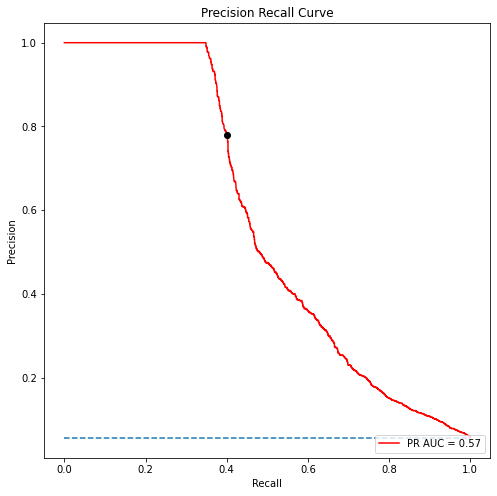

In [ ]:
y_prob_rf2 = rf2.predict_proba(X_test_enc)
precision_rf, recall_rf, thresholds = precision_recall_curve(y_test, y_prob_rf2[:,1])
pr_aucRF = auc(recall_rf, precision_rf)
plt.figure(figsize = (8,8))
plt.title('Precision Recall Curve')
plt.plot(recall_rf, precision_rf, color = 'red', label = 'PR AUC = %0.2f' % pr_aucRF)
plt.legend(loc = 'lower right')

# no_skill = Count of P / Total count
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1],  [no_skill, no_skill], linestyle = '--')

# Get best threshold
# convert to f score
fscore = (2 * precision_rf * recall_rf) / (precision_rf + recall_rf)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('\n')
plt.plot(recall_rf[ix], precision_rf[ix], marker='o', color='black', label='Best')

plt.axis('tight')
plt.ylabel('Precision')
plt.xlabel('Recall')

### Random Oversampling Minority class

Over sampling, Under sampling and SMOTE are methods from imblearn package<br>
**Note**: Apply the method on Train set and not the full data

In [ ]:
feat=list(X_train.columns)
oversample = over_sampling.RandomOverSampler(sampling_strategy=0.2)
X_over, y_over = oversample.fit_resample(X_train, y_train)
X_over_df = pd.DataFrame(data=X_over,columns=feat)
y_over_df = pd.DataFrame(data=y_over,columns=['is_canceled'])

In [ ]:
print('Before oversampling')
print('Class 1 samples --> ',y_train[y_train==1].shape[0])
print('Class 0 samples --> ', y_train[y_train==0].shape[0])

print('\nAfter oversampling')
print('Class 1 samples --> ',y_over[y_over==1].shape[0])
print('Class 0 samples --> ', y_over[y_over==0].shape[0])


Before oversampling
Class 1 samples -->  3095
Class 0 samples -->  52616

After oversampling
Class 1 samples -->  10523
Class 0 samples -->  52616


In [ ]:
cat_cols=['hotel','arrival_date_month','arrival_date_year','meal','market_segment','distribution_channel','reserved_room_type', 'assigned_room_type',\
        'deposit_type','customer_type']
X_train_enc = pd.get_dummies(data=X_over_df,columns=cat_cols,drop_first=True)
X_test_enc = pd.get_dummies(data=X_test,columns=cat_cols,drop_first=True)
X_train_enc,X_test_enc =X_train_enc.align(X_test_enc, join='left', axis=1)
X_test_enc=X_test_enc.fillna(0)

In [ ]:
rf3=RandomForestClassifier(max_depth=12,n_estimators=20,random_state=24)
rf3.fit(X_train_enc,y_over_df)
y_pred_rf3_train=rf3.predict(X_train_enc)
print("Train data f1 score: ", f1_score(y_over_df,y_pred_rf3_train))
y_pred_rf3=rf3.predict(X_test_enc)
print("Test data f1 score: ", f1_score(y_test,y_pred_rf3))

Train data f1 score:  0.5479754431951438
Test data f1 score:  0.5200445434298441


Best Threshold=0.382528, F-Score=0.549




Text(0.5, 0, 'Recall')

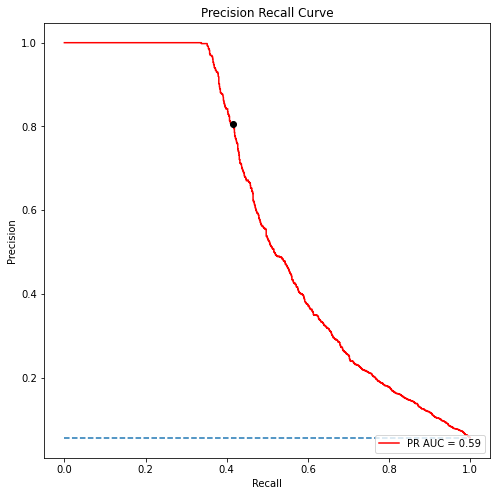

In [ ]:
y_prob_rf3 = rf3.predict_proba(X_test_enc)
precision_rf, recall_rf, thresholds = precision_recall_curve(y_test, y_prob_rf3[:,1])
pr_aucRF = auc(recall_rf, precision_rf)
plt.figure(figsize = (8,8))
plt.title('Precision Recall Curve')
plt.plot(recall_rf, precision_rf, color = 'red', label = 'PR AUC = %0.2f' % pr_aucRF)
plt.legend(loc = 'lower right')

# no_skill = Count of P / Total count
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1],  [no_skill, no_skill], linestyle = '--')

# Get best threshold
# convert to f score
fscore = (2 * precision_rf * recall_rf) / (precision_rf + recall_rf)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('\n')
plt.plot(recall_rf[ix], precision_rf[ix], marker='o', color='black', label='Best')

plt.axis('tight')
plt.ylabel('Precision')
plt.xlabel('Recall')

### Random Undersampling Majority class

In [ ]:
feat = list(X_train.columns)
undersample = under_sampling.RandomUnderSampler(sampling_strategy=0.2)
X_under, y_under = undersample.fit_resample(X_train, y_train)
X_under_df = pd.DataFrame(data=X_under,columns=feat)
y_under_df = pd.DataFrame(data=y_under,columns=['is_canceled'])
df_under_sample = pd.concat([X_under_df, y_under_df], axis=1, sort=False)

In [ ]:
print('Before undersampling')
print('Class 1 samples --> ',y_train[y_train==1].shape[0])
print('Class 0 samples --> ', y_train[y_train==0].shape[0])

print('\nAfter undersampling')
print('Class 1 samples --> ',y_under[y_under==1].shape[0])
print('Class 0 samples --> ', y_under[y_under==0].shape[0])

Before undersampling
Class 1 samples -->  3095
Class 0 samples -->  52616

After undersampling
Class 1 samples -->  3095
Class 0 samples -->  15475


In [ ]:
cat_cols=['hotel','arrival_date_month','arrival_date_year','meal','market_segment','distribution_channel','reserved_room_type', 'assigned_room_type',\
        'deposit_type','customer_type']
X_train_enc = pd.get_dummies(data=X_under_df,columns=cat_cols,drop_first=True)
X_test_enc = pd.get_dummies(data=X_test,columns=cat_cols,drop_first=True)
X_train_enc,X_test_enc =X_train_enc.align(X_test_enc, join='left', axis=1)
X_test_enc=X_test_enc.fillna(0)

In [ ]:
rf4=RandomForestClassifier(max_depth=10,n_estimators=20,random_state=24)
rf4.fit(X_train_enc,y_under_df)
y_pred_rf4_train=rf4.predict(X_train_enc)
print("Train data f1 score: ", f1_score(y_under_df,y_pred_rf4_train))
y_pred_rf4=rf4.predict(X_test_enc)
print("Test data f1 score: ", f1_score(y_test,y_pred_rf4))

Train data f1 score:  0.5123768324921893
Test data f1 score:  0.5137101287073308


Best Threshold=0.348586, F-Score=0.540




Text(0.5, 0, 'Recall')

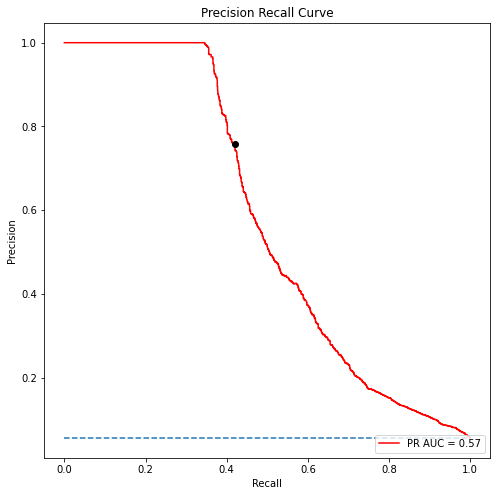

In [ ]:
y_prob_rf4 = rf4.predict_proba(X_test_enc)
precision_rf, recall_rf, thresholds = precision_recall_curve(y_test, y_prob_rf4[:,1])
pr_aucRF = auc(recall_rf, precision_rf)
plt.figure(figsize = (8,8))
plt.title('Precision Recall Curve')
plt.plot(recall_rf, precision_rf, color = 'red', label = 'PR AUC = %0.2f' % pr_aucRF)
plt.legend(loc = 'lower right')

# no_skill = Count of P / Total count
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1],  [no_skill, no_skill], linestyle = '--')

# Get best threshold
# convert to f score
fscore = (2 * precision_rf * recall_rf) / (precision_rf + recall_rf)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('\n')
plt.plot(recall_rf[ix], precision_rf[ix], marker='o', color='black', label='Best')

plt.axis('tight')
plt.ylabel('Precision')
plt.xlabel('Recall')

### Oversampling with SMOTE

Original Paper on SMOTE - "*SMOTE: synthetic minority over-sampling technique*" by N. V. Chawla, K. W. Bowyer, L. O.Hall, W. P. Kegelmeyer

In [ ]:
feat = list(X_train.columns)
undersample = under_sampling.RandomUnderSampler(sampling_strategy=0.1)
X_under, y_under = undersample.fit_resample(X_train, y_train)
X_under_df = pd.DataFrame(data=X_under,columns=feat)
y_under_df = pd.DataFrame(data=y_under,columns=['is_canceled'])

In [ ]:
print('Before oversampling')
print('Class 1 samples --> ',y_train[y_train==1].shape[0])
print('Class 0 samples --> ', y_train[y_train==0].shape[0])

print('\nAfter oversampling')
print('Class 1 samples --> ',y_under[y_under==1].shape[0])
print('Class 0 samples --> ', y_under[y_under==0].shape[0])

Before oversampling
Class 1 samples -->  3095
Class 0 samples -->  52616

After oversampling
Class 1 samples -->  3095
Class 0 samples -->  30950


In [ ]:
c=[0,2,3,6,7,8,10,11,13,15]
X_train.columns[c]

Index(['hotel', 'arrival_date_year', 'arrival_date_month', 'meal',
       'market_segment', 'distribution_channel', 'reserved_room_type',
       'assigned_room_type', 'deposit_type', 'customer_type'],
      dtype='object')

In [ ]:
cat_cols=[0,2,3,6,7,8,10,11,13,15]
oversample = over_sampling.SMOTENC(categorical_features=cat_cols,sampling_strategy=0.12)
X_over, y_over = oversample.fit_resample(X_under, y_under)
X_over_df_smote = pd.DataFrame(data=X_over,columns=feat)
y_over_df_smote = pd.DataFrame(data=y_over,columns=['is_canceled'])

In [ ]:
print('Before oversampling')
print('Class 1 samples --> ',y_under[y_under==1].shape[0])
print('Class 0 samples --> ', y_under[y_under==0].shape[0])

print('\nAfter oversampling')
print('Class 1 samples --> ',y_over[y_over==1].shape[0])
print('Class 0 samples --> ', y_over[y_over==0].shape[0])

Before oversampling
Class 1 samples -->  3095
Class 0 samples -->  30950

After oversampling
Class 1 samples -->  3714
Class 0 samples -->  30950


In [ ]:
cat_cols=['hotel','arrival_date_month','arrival_date_year','meal','market_segment','distribution_channel','reserved_room_type', 'assigned_room_type',\
        'deposit_type','customer_type']
X_train_enc = pd.get_dummies(data=X_over_df_smote,columns=cat_cols,drop_first=True)
X_test_enc = pd.get_dummies(data=X_test,columns=cat_cols,drop_first=True)
X_train_enc,X_test_enc =X_train_enc.align(X_test_enc, join='left', axis=1)
X_test_enc=X_test_enc.fillna(0)

In [ ]:
rf5=RandomForestClassifier(max_depth=12,n_estimators=20,random_state=24)
rf5.fit(X_train_enc,y_over_df_smote)
y_pred_rf5_train=rf5.predict(X_train_enc)
print("Train data f1 score: ", f1_score(y_over_df_smote,y_pred_rf5_train))
y_pred_rf5=rf5.predict(X_test_enc)
print("Test data f1 score: ", f1_score(y_test,y_pred_rf5))

Train data f1 score:  0.5503512880562061
Test data f1 score:  0.510662177328844


Best Threshold=0.273619, F-Score=0.551




Text(0.5, 0, 'Recall')

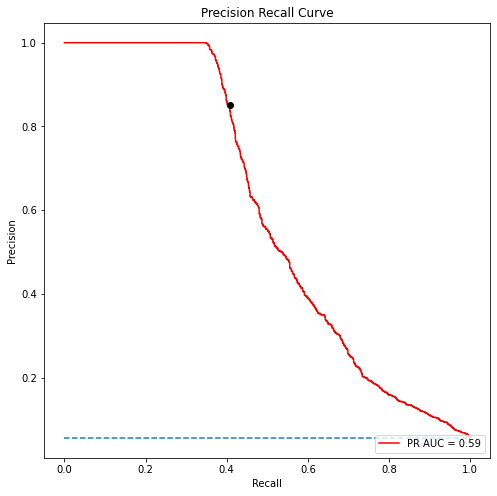

In [ ]:
y_prob_rf5 = rf5.predict_proba(X_test_enc)
precision_rf, recall_rf, thresholds = precision_recall_curve(y_test, y_prob_rf5[:,1])
pr_aucRF = auc(recall_rf, precision_rf)
plt.figure(figsize = (8,8))
plt.title('Precision Recall Curve')
plt.plot(recall_rf, precision_rf, color = 'red', label = 'PR AUC = %0.2f' % pr_aucRF)
plt.legend(loc = 'lower right')

# no_skill = Count of P / Total count
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1],  [no_skill, no_skill], linestyle = '--')

# Get best threshold
# convert to f score
fscore = (2 * precision_rf * recall_rf) / (precision_rf + recall_rf)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('\n')
plt.plot(recall_rf[ix], precision_rf[ix], marker='o', color='black', label='Best')

plt.axis('tight')
plt.ylabel('Precision')
plt.xlabel('Recall')

# Regression

In [2]:
boston_raw = datasets.load_boston()
#boston_raw is of sklearn internal datatype. Converting it to pandas dataframe so we can analyze the data easier
boston = pd.DataFrame(boston_raw.data, columns=boston_raw.feature_names)
#target is the predict_to column, in this case it is medv and numerical in nature.
boston['MEDV'] = boston_raw.target
boston.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [3]:
print(boston_raw.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [ ]:
boston['MEDV'].describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: MEDV, dtype: float64

Adding artificial outliers to see difference in Loss functions 

In [ ]:
s = boston[boston['MEDV']==50].shape[0]
boston.loc[(boston['MEDV']==50),'MEDV'] = np.random.randint(50,70, size=s)

In [ ]:
boston[boston['MEDV']>50].shape

(16, 14)

<b> Feature Engineering

In [5]:
y = boston["MEDV"]
X = boston.drop(["MEDV"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [8]:
X_train.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
mean,3.469887,11.403955,11.133051,0.073446,0.557259,6.325672,68.799718,3.765874,9.437853,407.042373,18.277966,359.701808,12.421130
std,8.315831,22.608457,6.938651,0.261237,0.116792,0.719211,27.665360,2.126032,8.639971,166.522237,2.256792,86.924779,7.112402
min,0.009060,0.000000,1.210000,0.000000,0.385000,3.863000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082320,0.000000,5.130000,0.000000,0.450000,5.889500,46.025000,2.073700,4.000000,279.000000,16.650000,376.782500,6.862500
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.227500,77.350000,3.107300,5.000000,330.000000,18.600000,391.600000,10.925000
75%,3.281688,20.000000,18.100000,0.000000,0.631000,6.681750,93.475000,5.400700,24.000000,666.000000,20.200000,396.172500,16.225000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


### Min-Max scaler
$x_{scaled} = \frac{(x – min)}{(max – min)}$


In [ ]:
min_max_scaler = MinMaxScaler()
boston_train_norm = pd.DataFrame(min_max_scaler.fit_transform(X_train), columns=X_train.columns)

boston_test_norm = pd.DataFrame(min_max_scaler.transform(X_test), columns=X_test.columns)

### Building Linear Regression

Model 1

In [ ]:
linreg1 = LinearRegression()
linreg1.fit(X_train, y_train)
y_pred_L2 = linreg1.predict(X_test)

### Loss function

<b>Mean Absolute Error (MAE) --  $MAE = \frac{1}{N} \sum_{j=1}^{N}|y_j-\hat{y_j}|$<br><br>
<b>Root Mean SQuared Error (RMSE) --  $RMSE = \sqrt {\frac{\sum_{j=1}^{N}(y_j-\hat{y_j})^2}{N}}$<br>


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_L2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_L2)))

Mean Absolute Error: 3.558273155310644
Root Mean Squared Error: 5.440578713331204


<b>R-squared -- $R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ <br><br>
Adjusted R-squared </b> -- $ R^2_{adj} = 1- \frac{( 1-R^2 )( n-1 )}{n-k-1}$

In [ ]:
r2 = metrics.r2_score(y_test,y_pred_L2)
print('R-squared: ',r2 )

R-squared:  0.6599718561838986


In [ ]:
n = X_train.shape[0]
k = X_train.shape[1]
adj_r2 = 1 - (((1-r2)*(n-1))/(n-k-1))
print('Adjusted R-squared',adj_r2)

Adjusted R-squared 0.6469707800968124


<b> K fold cross validation

In [ ]:
print('MAE')
scores = cross_val_score(linreg1, X, y, cv = 5, scoring='neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

print('\nRMSE')
scores = cross_val_score(linreg1, X, y, cv = 5, scoring='neg_root_mean_squared_error')
print(scores)
print(np.mean(scores))

print('\n R2')
scores = cross_val_score(linreg1, X, y, cv = 5, scoring='r2')
print(scores)
print(np.mean(scores))

MAE
[-2.90384761 -4.57628984 -4.96339894 -6.26688493 -5.41613252]
-4.825310770617206

RMSE
[ -3.85977353  -6.67115752  -6.94165475 -10.88127025  -6.4981679 ]
-6.970404788830733

 R2
[ 0.56861829  0.63983696  0.54845279 -0.01774978 -0.58814815]
0.23020202088132194


### Model 2 - Remove outliers

In [ ]:
boston = boston[boston['MEDV']<50]

In [ ]:
boston['MEDV'].describe()

count    490.000000
mean      21.635918
std        7.865301
min        5.000000
25%       16.700000
50%       20.900000
75%       24.675000
max       48.800000
Name: MEDV, dtype: float64

In [ ]:
y = boston["MEDV"]
X = boston.drop(["MEDV"], axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
min_max_scaler = MinMaxScaler()
boston_train_norm2 = pd.DataFrame(min_max_scaler.fit_transform(X_train2), columns=X_train2.columns)

boston_test_norm2 = pd.DataFrame(min_max_scaler.transform(X_test2), columns=X_test2.columns)

In [ ]:
linreg2 = LinearRegression()
linreg2.fit(X_train2, y_train2)
y_pred_L2_2 = linreg2.predict(X_test2)

In [ ]:
print('MAE')
scores = cross_val_score(linreg2, X, y, cv = 5, scoring='neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

print('\nRMSE')
scores = cross_val_score(linreg2, X, y, cv = 5, scoring='neg_root_mean_squared_error')
print(scores)
print(np.mean(scores))

print('\n R2')
scores = cross_val_score(linreg2, X, y, cv = 5, scoring='r2')
print(scores)
print(np.mean(scores))

MAE
[-2.42612842 -2.58481317 -3.93996484 -4.54571332 -3.78682099]
-3.4566881469885815

RMSE
[-3.11256487 -3.47210032 -5.42757235 -6.46566865 -4.65087812]
-4.625756862858151

 R2
[0.67122329 0.77373836 0.53130089 0.00834599 0.11865916]
0.420653536616782
